# Hypothesis 


Idea:
Seniors will take shorter trips on Citi Bike than younger people.

Null Hypothesis:
The mean trip duration of seniors' rides is greater than or equal to that of younger people.

H0:
The mean trip duration of trips taken by people born before 1953 (65 year old senior citizen) is greater than or not more than 2 sigma lower of the mean those of other ages.

$$ Mean(Senior Trip Duration) \geq  Mean(Younger Trip Duration) $$

H1:
The mean trip duration of trips taken by people born before 1953 (65 year old senior citizen) is more than 2 sigma lower of the mean those of other ages.

$$ Mean(Senior Trip Duration) <  Mean(Younger Trip Duration) $$

I want to use the trip duration column and the birth year columns of the data.  I also want to remove all rows that have a NaN value in the birth year column.

The data I'm going to use is from January July 2016 

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import statsmodels.stats.weightstats as ws
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#read in 2 files and concat
df_jan = pd.read_csv('/gws/open/Student/citibike/201601-citibike-tripdata.zip', compression='infer')
df_july = pd.read_csv('/gws/open/Student/citibike/201607-citibike-tripdata.zip', compression='infer')
df = pd.concat([df_jan, df_july])
print(df.shape)
df.head()

(1889588, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


Text(0.5,0,'Rider Birth Year')

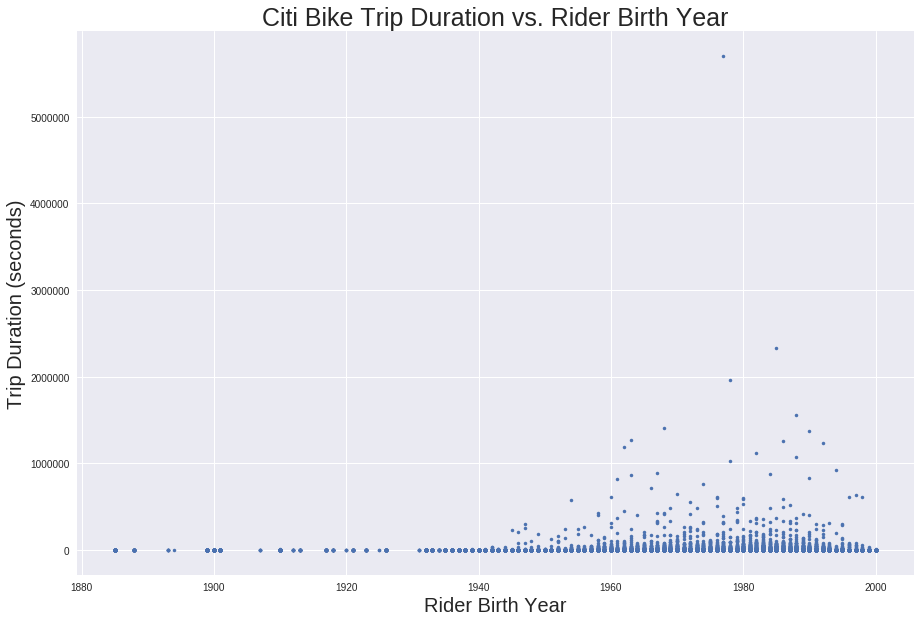

In [3]:
# Interested in distribution of birth year and trip duration and outliers
pl.figure(figsize=(15, 10))
pl.plot(df['birth year'], df['tripduration'], '.')
pl.title('Citi Bike Trip Duration vs. Rider Birth Year', fontsize = 25 )
pl.ylabel('Trip Duration (seconds)', fontsize = 20)
pl.xlabel('Rider Birth Year', fontsize = 20)

Figure 1: Scatter plot of trip duration vs. birth year shows few rider claiming to be extremely elderly, likely do to errors or intentionally incorrect inputs.

Text(0.5,1,'Histogram of Trip Duration (seconds)')

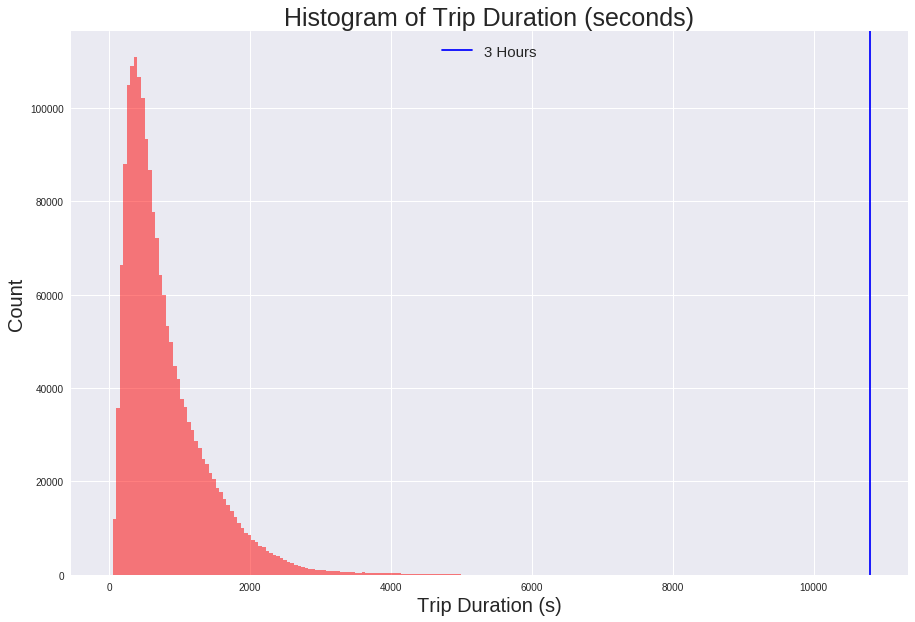

In [4]:
# Histogram of just tripduration
bins = numpy.linspace(0, 5000, 100)

pl.figure(figsize=(15, 10))
pl.hist(df['tripduration'], bins=bins, alpha=0.5, color='red')
pl.axvline(3 * 60 * 60, label = '3 Hours', c = 'blue')
pl.legend(loc='upper center', fontsize = 15)
pl.xlabel('Trip Duration (s)', fontsize = 20)
pl.ylabel('Count', fontsize = 20)
pl.title('Histogram of Trip Duration (seconds)', fontsize = 25)

Figure 2: Histogram of trip duration shows a lognormal distribution of trip times.  Also shown is a bar for a 3 hour trip which I will use as a cutoff to remove trips that did not have bikes docked correctly at their destination.  As a subsriber to Citi Bike, a 3 hour trip would cost an addition $22.50 on top of your yearly subscription.  Doing that on purpose seems unlikely.  

In [5]:
# remove any rows with NaN for Birth Year
# I'm still going to drop NaNs even though I was suggested that I convert them to the mean birth year
# This is because It would just be adding ride to the non-senior group
df = df.dropna(subset=['birth year'])

pd.crosstab(df['usertype'], df['birth year'],margins=True)

birth year,1885.0,1888.0,1893.0,1894.0,1899.0,1900.0,1901.0,1907.0,1910.0,1912.0,...,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,All
usertype,,,,,,,,,,,,,,,,,,,,,
Customer,0,0,0,0,0,0,0,0,0,0,...,81,82,109,102,61,62,71,0,0,2614
Subscriber,178,31,6,1,56,298,56,5,59,8,...,41900,28009,14390,11057,7027,4623,3917,2113,481,1658834
All,178,31,6,1,56,298,56,5,59,8,...,41981,28091,14499,11159,7088,4685,3988,2113,481,1661448


In [6]:
# It was reccomended that I remove riders above the age of 90 since those ages are likely false
df = df[df['birth year'] > 1927]

# Also removing any ride with shorter than 30 seconds (not a ride) 
#and more than 3 hours(costs get pretty high, likely left bike somewhere by mistake)
df = df[(df['tripduration'] > 30) & (df['tripduration'] < ( 3 * 60 * 60))]

print(df.shape)

(1658734, 15)


In [7]:
# drop extra columns
df.drop([ 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
        'gender'] , axis=1, inplace=True)
df.head()

,tripduration,birth year
0,923,1958.0
1,379,1969.0
2,589,1982.0
3,889,1961.0
4,1480,1952.0


In [8]:
# Add a column for Senior or not
def sen_or_no(year) :
    if year < 1953:
        return(1)
    else:
        return(0)
df['senior'] = df['birth year'].apply(lambda x: sen_or_no(x))
# check values
pd.crosstab(df['senior'], df['birth year'],margins=True)

birth year,1931.0,1932.0,1933.0,1934.0,1935.0,1936.0,1937.0,1938.0,1939.0,1940.0,...,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,All
senior,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,41937,28068,14489,11133,7074,4674,3983,2111,481,1618803
1,5,102,49,17,90,109,54,496,278,687,...,0,0,0,0,0,0,0,0,0,39931
All,5,102,49,17,90,109,54,496,278,687,...,41937,28068,14489,11133,7074,4674,3983,2111,481,1658734


Text(0,0.5,'Count')

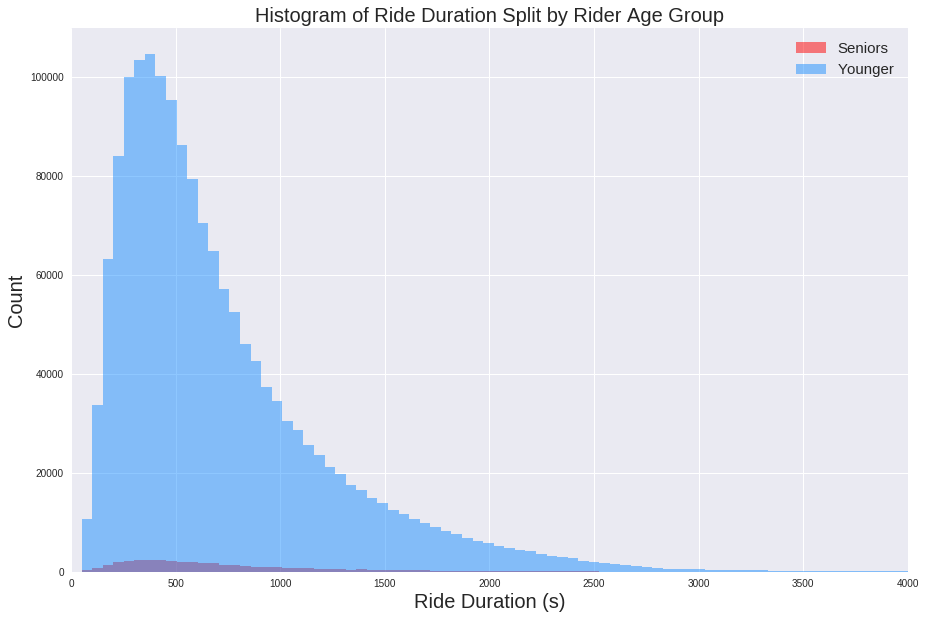

In [9]:
# Look at the distributions of tripduration split by senior
bins = numpy.linspace(0, 5000, 100)
pl.figure(figsize=(15, 10))
pl.hist(df['tripduration'][df['senior'] == 1], bins=bins, alpha=0.5, label='Seniors', color='red')
pl.hist(df['tripduration'][df['senior'] == 0], bins=bins, alpha=0.5, label='Younger', color='dodgerblue')
pl.xlim(0,4000)
pl.legend(loc='upper right', fontsize=15)
pl.title('Histogram of Ride Duration Split by Rider Age Group', fontsize=20)
pl.xlabel('Ride Duration (s)', fontsize=20)
pl.ylabel('Count', fontsize=20 )

Figure 3: The histogram of ride duration with outliers removed split by rider age group shows what looks like lognormal distributions for both groups.

Text(0,0.5,'Count')

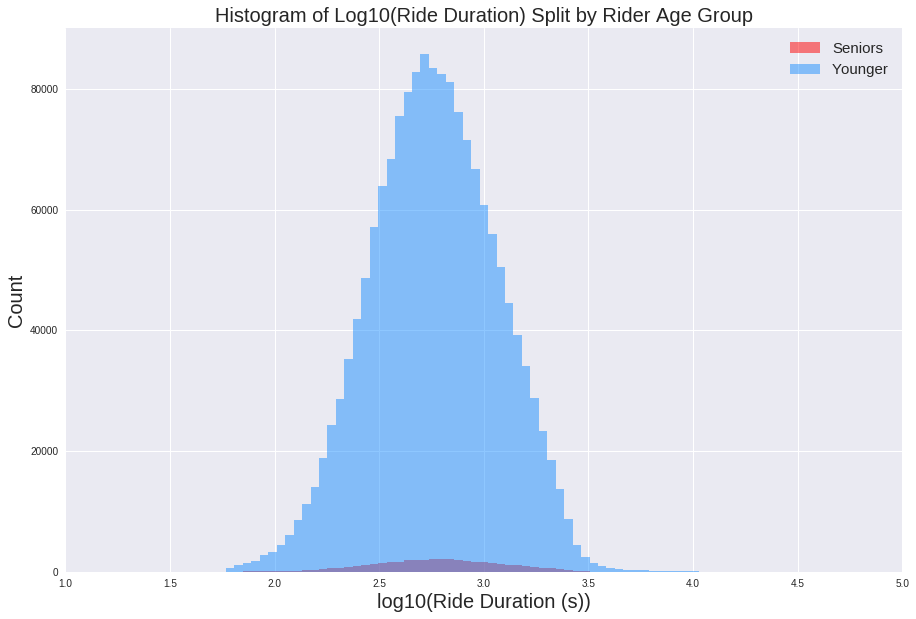

In [10]:
# I would like to use a z-test to compare the groups and they look lognormal so I will log transform the trip duration
df['log_td'] = np.log10(df['tripduration'])
bins = numpy.linspace(1, 5, 100)
pl.figure(figsize=(15, 10))
pl.hist(df['log_td'][df['senior'] == 1], bins=bins, alpha=0.5, label='Seniors', color='red')
pl.hist(df['log_td'][df['senior'] == 0], bins=bins, alpha=0.5, label='Younger', color='dodgerblue')
pl.xlim(1,5)
pl.legend(loc='upper right', fontsize=15)
pl.title('Histogram of Log10(Ride Duration) Split by Rider Age Group', fontsize=20)
pl.xlabel('log10(Ride Duration (s))', fontsize=20)
pl.ylabel('Count', fontsize=20 )

Figure 4: Histogram of log10(Trip Durations) shows data is relatively close to normal distribution.

In [11]:
# It was reccomended that I use a chi-sq for proportions test to test my hypothesis
# I disagree with this since I am comparing means of values not the counts
# If I had split rides into groups of short and long then the chi-sq for proportions would make sense
# Instead I used a two sample z-test since my data is normally distributed.
z_score, p_val = (ws.ztest(df['log_td'][df['senior'] == 1], df['log_td'][df['senior'] == 0],
              alternative = 'smaller'))
print('The z statistic for the test is '+  str(z_score))
print('The associated p-val for the z statistic is ' + str(p_val))

The z statistic for the test is 13.7960553608
The associated p-val for the z statistic is 1.0


We using a two sample z-test we find that the z test statistic with our null hypotheis being that the mean for the senior group is greater than or equal to that of the non-senior group.  

([<matplotlib.axis.XTick at 0x7f26958827b8>,
 <a list of 2 Text xticklabel objects>)

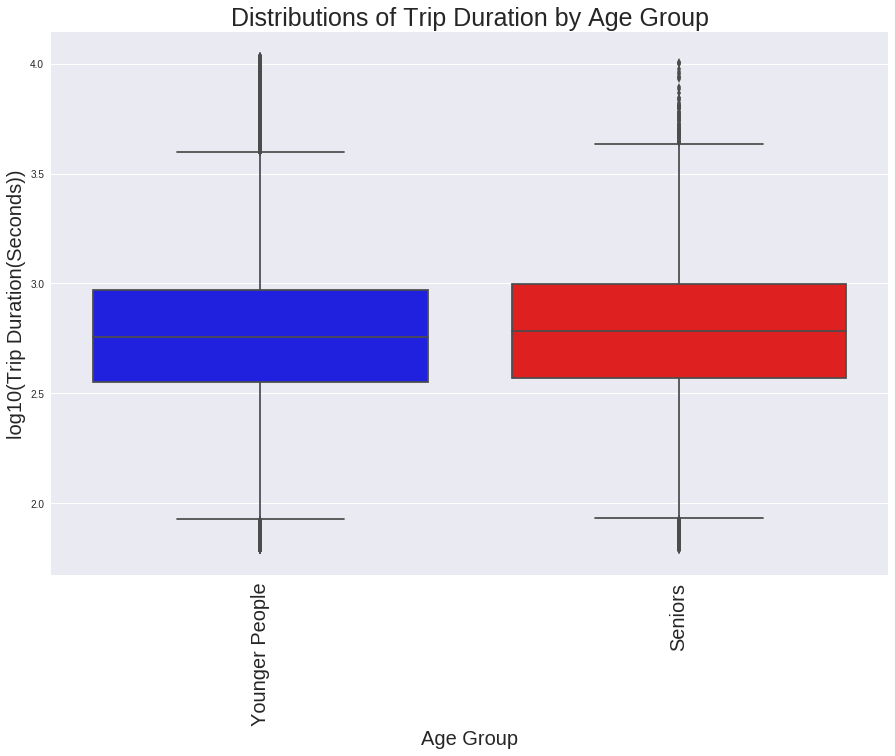

In [12]:
pl.figure(figsize=(15, 10))
my_pal = {1 : "r", 0 : "b"}
sns.boxplot(x='senior', y='log_td', data=df, palette=my_pal)
#plt.ylim(0, 2000)
plt.title('Distributions of Trip Duration by Age Group', fontsize = 25)
plt.xlabel('Age Group', fontsize = 20)
plt.ylabel('log10(Trip Duration(Seconds))', fontsize = 20)
plt.xticks([0,1], ['Younger People', 'Seniors'], rotation='vertical', fontsize = 20)

Fig 5: This boxplot of log10 transformed trip durations for seniros and younger people shows that there is clearly not a significant difference in means between senior trip durations and younger people's trip durations